In [1]:
import pandas as pd
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
plt.style.use('seaborn-whitegrid')

from utils import PkdbModel, abs_idx,rel_idx,group_idx,individual_idx \

plt.rcParams.update({
        'axes.labelsize': '20',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': '20',
        'xtick.labelsize': '20',
        'ytick.labelsize': '20',
        'figure.facecolor': '1.00'
    })


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.read()
caffeine_clearance = caffeine_clr.data
caffeine_clearance["outlier"] = False


In [4]:
caffeine_clearance.loc[caffeine_clearance["study"]== "Balogh1992","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1988","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1989","outlier"] = True

In [5]:

def control_idx(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & ((data[ ('oral contraceptives', 'choice')] == 'N') | ((data[('oral contraceptives', 'choice')].isnull()) & (data[('medication', 'choice')] == "N")))

def smoking_idx(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
           & (data.outlier == False) \

def oc_idx(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') 

def outlier_idx(data):
    return  data.outlier == True

def rest_idx(data):
    return (~outlier_idx(data) & ~smoking_idx(data)  & ~oc_idx(data) & ~control_idx(data))

In [6]:
class FigureTemplate(object):
    def __init__(self,data_idx,intervention_type, output_type):
        self.data_idx = data_idx,
        self.intervention_type = intervention_type
        self.output_type = output_type
        self.figure=False,
        self.ax = False
    
    def data_subset(self,data):
        return data.loc[self.data_idx]
    
    def create_figure(self, data):
        if len(self.data_subset(data)) > 0:
             self.figure, self.ax  =  plt.subplots(nrows=1, ncols=1, figsize=(15, 7.5))
                
   

        
    

In [7]:
PlotCategory =  namedtuple('PlotCategory', ['name','color', 'marker','data_idx'])

def control_idx_strict(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'N')
def smoking_idx_strict(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
         & (data[ ('oral contraceptives', 'choice')] == 'N') \
           & (data.outlier == False) 

def oc_idx_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'N') 

def oc_smoking_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'Y') 

def rest_idx_strict(data):
        return (~control_idx_strict(data) & ~smoking_idx_strict(data) & ~oc_smoking_strict(data)  & ~oc_idx_strict(data) & ~outlier_idx(data))



In [8]:
categories_soft = [PlotCategory(name="control", color='black', marker='s', data_idx=control_idx),
              PlotCategory(name="smoking", color='blue', marker='d', data_idx=smoking_idx),
              PlotCategory(name="oc", color='green', marker='o', data_idx=oc_idx),
              PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
              PlotCategory(name="rest", color='brown', marker='x', data_idx=rest_idx),
             ]

In [9]:
categories_strict = [PlotCategory(name="control", color='black', marker='s', data_idx=control_idx_strict),
              PlotCategory(name="smoking", color='blue', marker='d', data_idx=smoking_idx_strict),
              PlotCategory(name="oc", color='green', marker='o', data_idx=oc_idx_strict),
              PlotCategory(name="oc-smoking", color='orange', marker='v', data_idx=oc_smoking_strict),
              PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
              PlotCategory(name="rest", color='brown', marker='x', data_idx=rest_idx_strict),
             ]

In [10]:


def create_figures(df_data):
    figure_templates = [FigureTemplate(
        data_idx= abs_idx(df_data,"unit_intervention") & abs_idx(df_data,"unit"),
        intervention_type = "abs",
        output_type = "abs"
                  ),
    FigureTemplate(
        data_idx= rel_idx(df_data,"unit_intervention") & abs_idx(df_data,"unit"),
        intervention_type = "rel",
        output_type = "abs"
                  ),
    FigureTemplate(
        data_idx= abs_idx(df_data,"unit_intervention") & rel_idx(df_data,"unit"),
        intervention_type = "abs",
        output_type = "rel"
                  ),
    FigureTemplate(
        data_idx= rel_idx(df_data,"unit_intervention") & rel_idx(df_data,"unit"),
        intervention_type = "rel",
        output_type = "rel"
                  )
    ]
    
    for figure_template in figure_templates:
        
        figure_template.create_figure(df_data)
    return figure_templates
        
    
    


In [11]:

def create_plots(df_data,categories,fig_path,pktype):
    
    
    figures = create_figures(df_data)
    
    for figure in figures:
        if figure.ax:
            df_figure = figure.data_subset(df_data)
            
            df_figure_max = max([df_figure["value"].max(),df_figure["mean"].max()])*1.05
            
            
        
            df_individual = df_figure[individual_idx(df_data)]
            df_group = df_figure[group_idx(df_data)]


            for plot_category in categories:
                df_category = df_individual[plot_category.data_idx(df_individual)]
                x = df_category["value_intervention"]
                y = df_category["value"]
                figure.ax.scatter(x, y,color=plot_category.color, marker=plot_category.marker, alpha=0.5,label=None,  s=20)
                units = df_category["unit"].unique()
                unit_intervention = df_category["unit_intervention"].unique()

                assert len(units) <= 1, units
                try:
                    figure.ax.set_ylabel(f'caffeine {pktype} [{units[0]}]')
                    figure.ax.set_xlabel(f'caffeine dose [{unit_intervention[0]}]')
                    figure.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

                except IndexError: 
                    pass

                df_category = df_group[plot_category.data_idx(df_group)]
                df_category = df_category[df_category["mean"].notnull()]
                x_group = df_category["value_intervention"]
                y_group = df_category["mean"]

                if figure.output_type == "rel":
                    xerr_group = (df_category[("weight","sd")]/df_category[("weight","mean")])*x_group
                else:
                    xerr_group = 0
                yerr_group = df_category["se"]

                figure.ax.errorbar(x_group, y_group,yerr=yerr_group,xerr=xerr_group, color=plot_category.color, fmt=plot_category.marker,  label=f"{plot_category.name}(Individuals.:{len(x)},Groups:{len(x_group)})",ms=10, alpha=0.7)
                for i, txt in enumerate(df_category[('study', '')]):
                    figure.ax.annotate(txt, (x_group.iloc[[i]]+(0.01*x_group.max()),
                                      y_group.iloc[[i]]+(0.01*y_group.max())), alpha=0.7)

                figure.ax.set_title(pktype.capitalize())
                figure.ax.set_xlim(left=0)
                figure.ax.set_ylim(bottom=0, top=df_figure_max)
                figure.ax.legend()
                figure.figure.savefig(os.path.join(fig_path,f"{pktype}_{figure.output_type}-vs-dosing_{figure.intervention_type}.svg"), bbox_inches="tight")



                

   

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


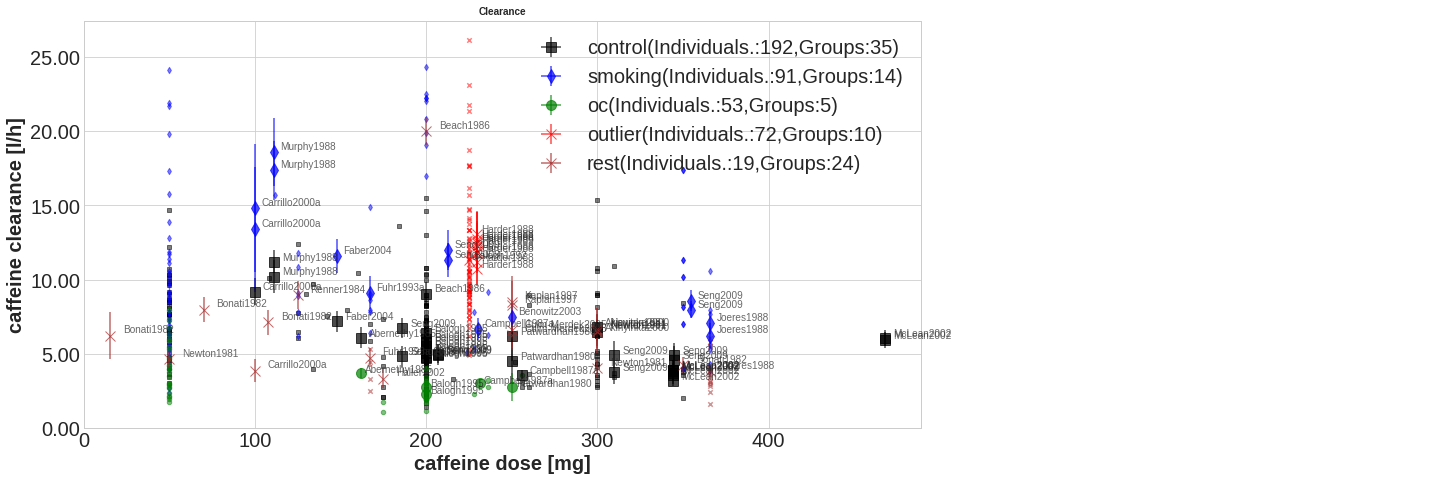

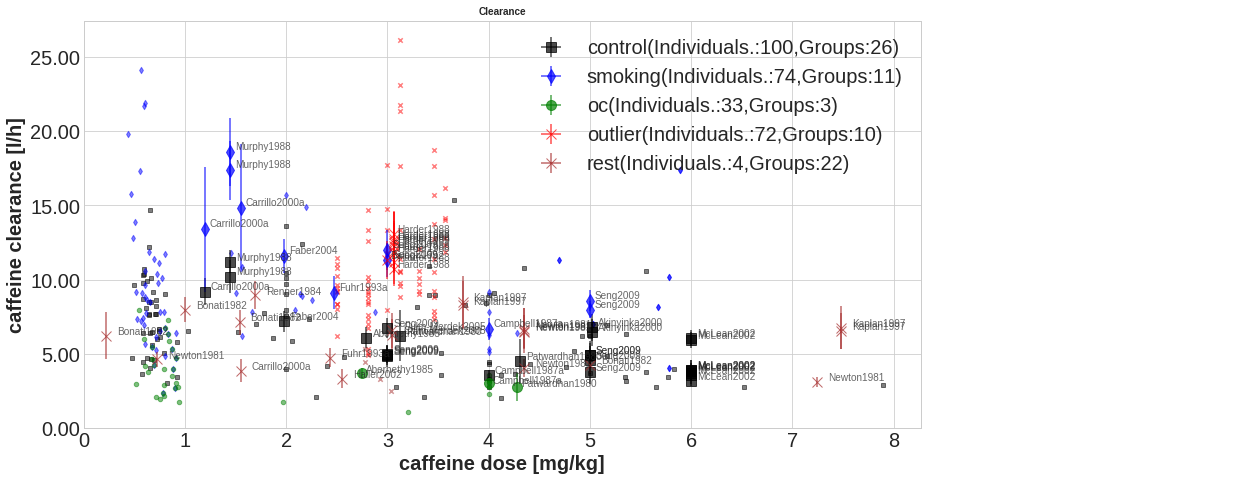

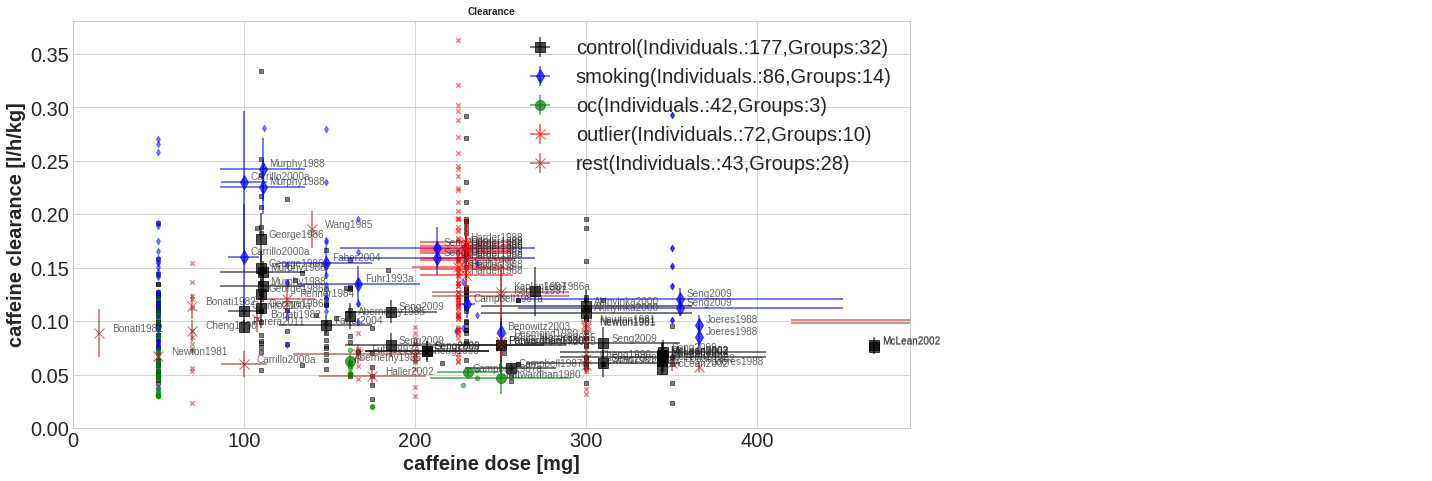

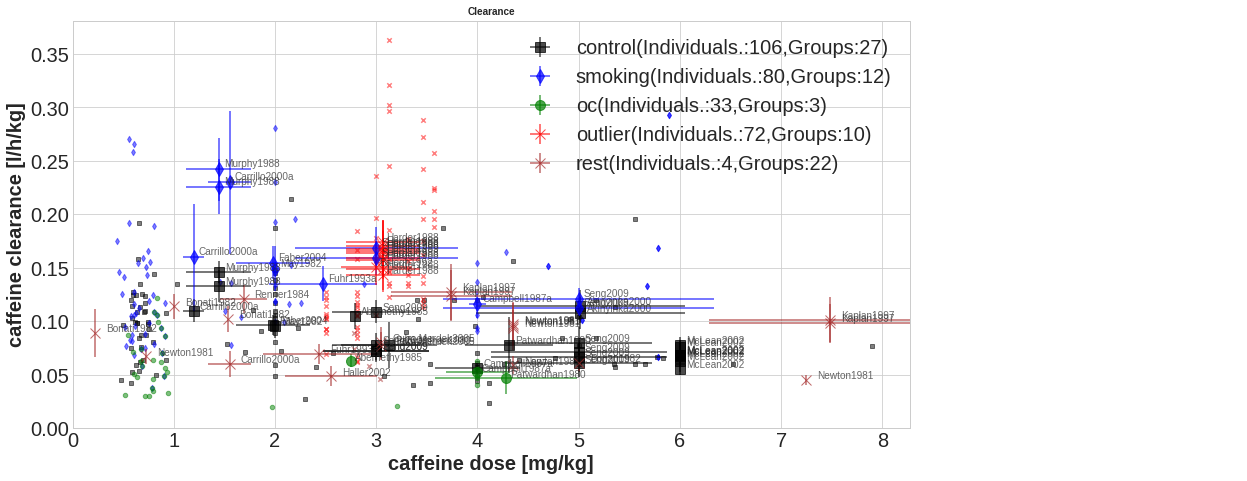

In [12]:
create_plots(caffeine_clearance,categories_soft,"reports/soft","clearance")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


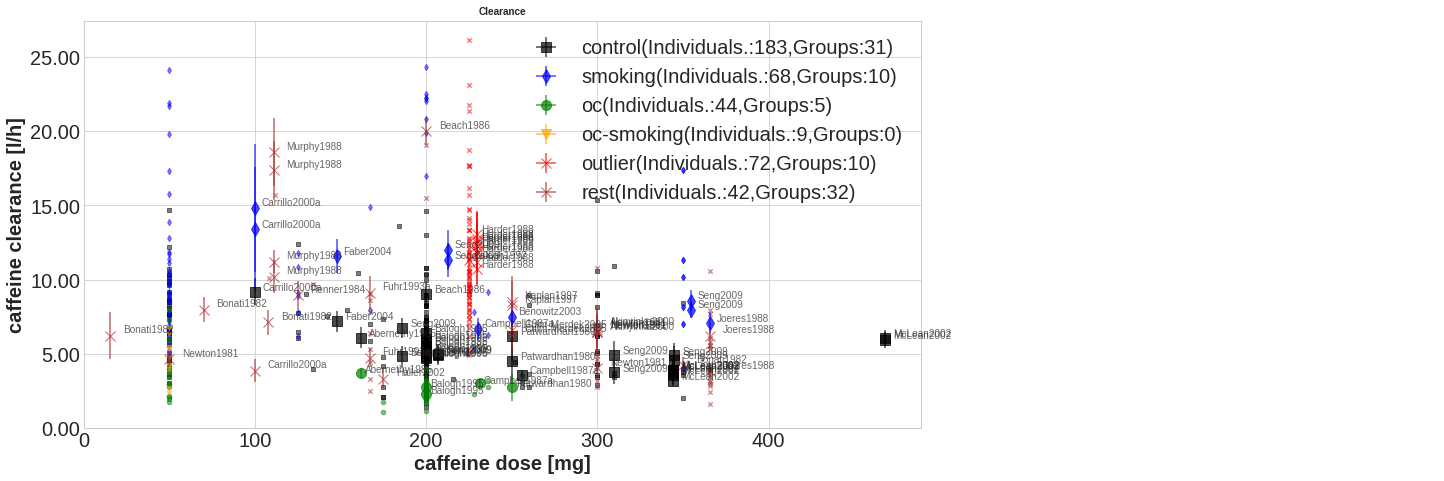

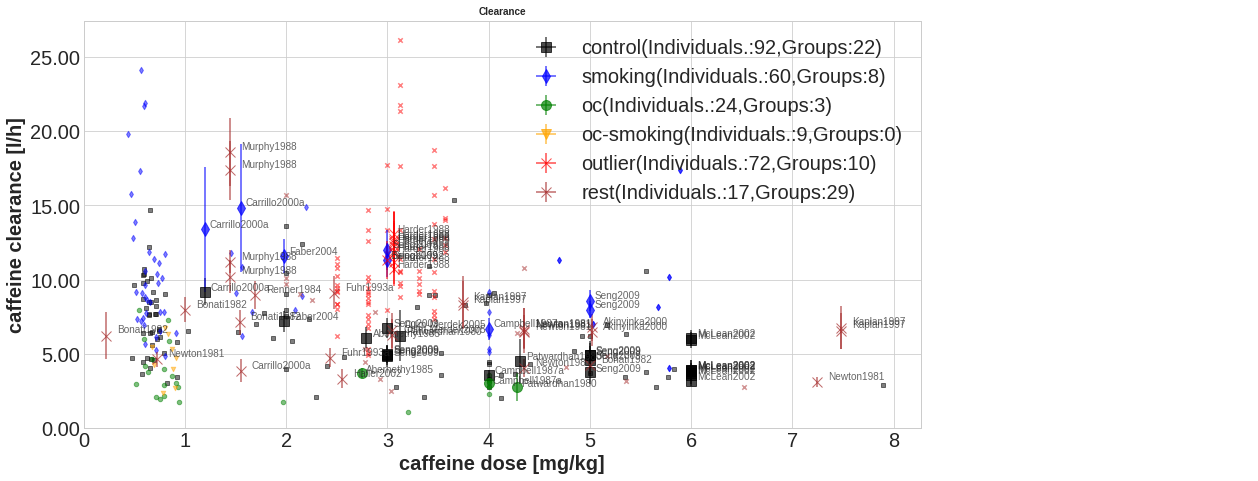

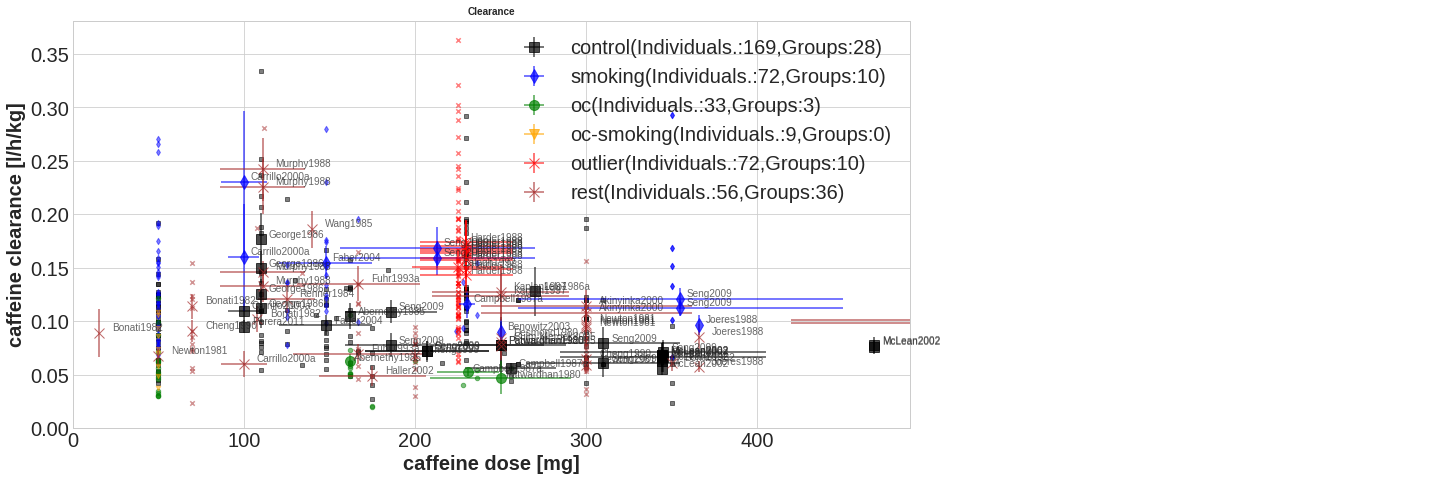

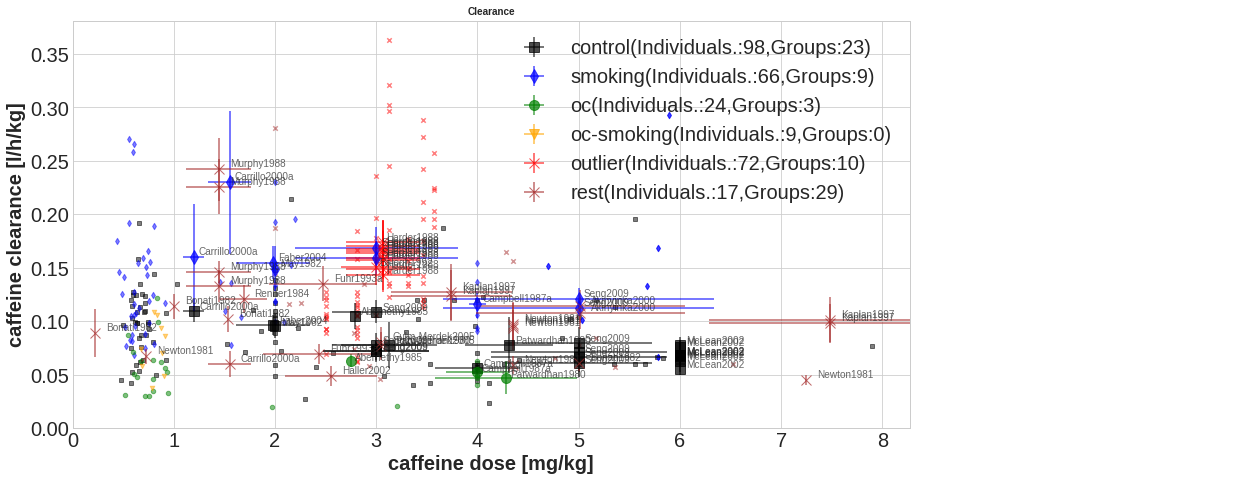

In [13]:
create_plots(caffeine_clearance,categories_strict,"reports/strict","clearance")

In [14]:
caffeine_clearance[abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit")].groupby("subject_type").count()

study  output_type   pk  tissue  substance_name  pktype  unit  \
subject_type                                                                  
group            89           89   89      89              89      89    89   
individual      418          418  418     418             418     418   418   

              interventions  individual_pk  value   ...     \
subject_type                                        ...      
group                    89              0      0   ...      
individual              418            418    418   ...      

              (metabolic ratio, max)  (metabolic ratio, mean)  \
subject_type                                                    
group                              0                        0   
individual                         0                        0   

              (metabolic ratio, min)  (metabolic ratio, unit)  \
subject_type                                                    
group                              0                        0   
individual                         0                        0   

              (fat weight, count)  (fat weight, cv)  (fat weight, mean)  \
subject_type                                                              
group                           8                 8                   8   
individual                      0                 0                   0   

              (fat weight, se)  (fat weight, unit)  outlier  
subject_type                                                 
group                        8                   8       89  
individual                   0                   0      418  

[2 rows x 268 columns]

In [15]:
caffeine_thf = PkdbModel("caffeine_thalf",destination="3-inferred")
caffeine_thf.read()
caffeine_thalf = caffeine_thf.data
caffeine_thalf["outlier"] = False
caffeine_thalf.loc[caffeine_thalf["study"]== "Balogh1992","outlier"] = True
caffeine_thalf.loc[caffeine_thalf["study"]== "Harder1988","outlier"] = True
caffeine_thalf.loc[caffeine_thalf["study"]== "Harder1989","outlier"] = True

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


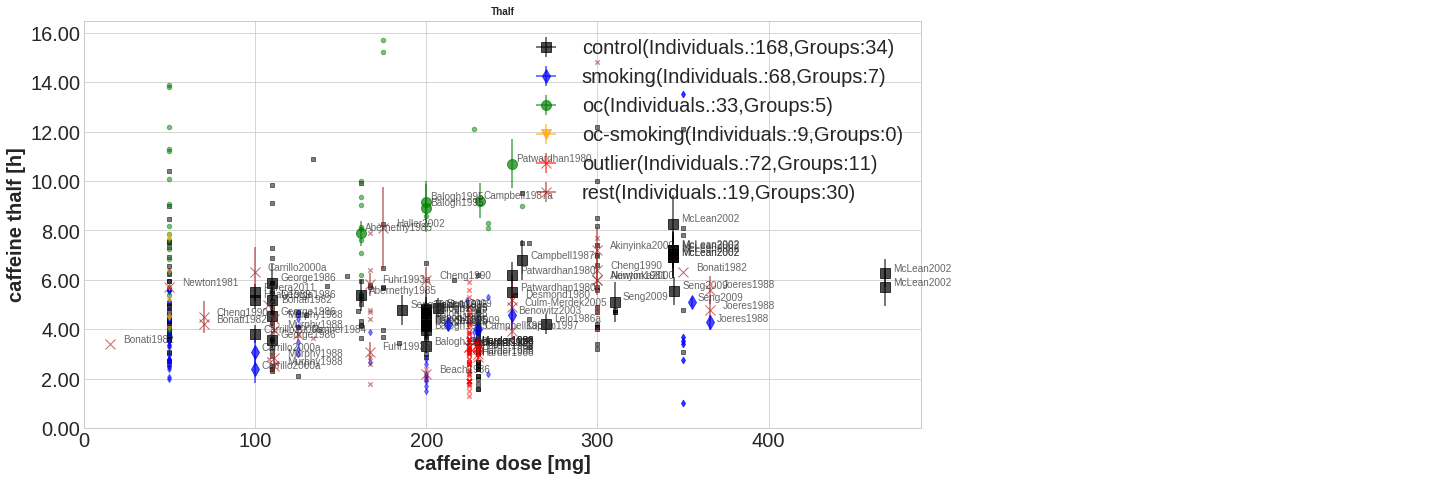

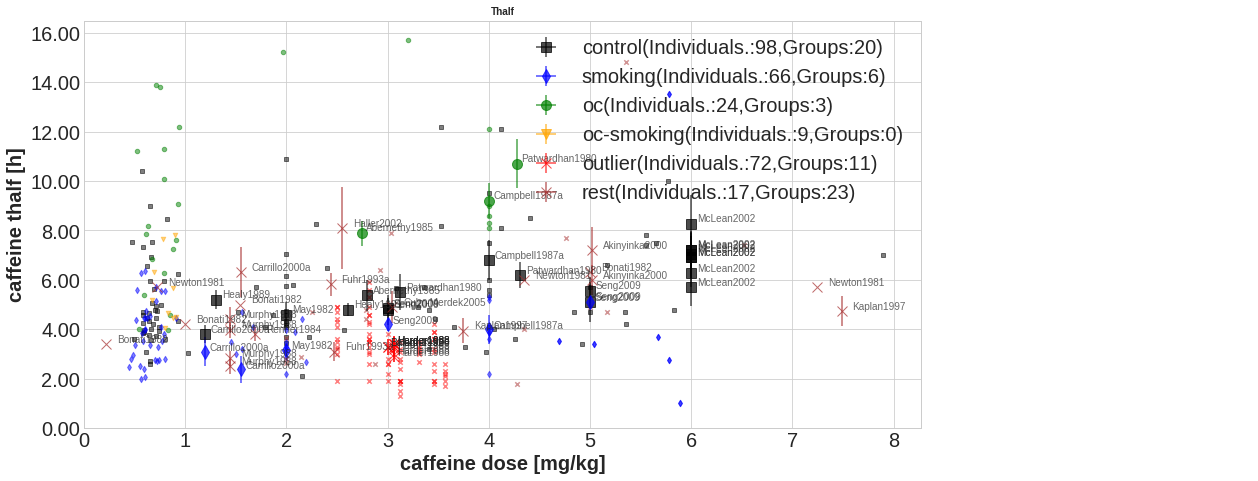

In [16]:
create_plots(caffeine_thalf,categories_strict,"reports/strict","thalf")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


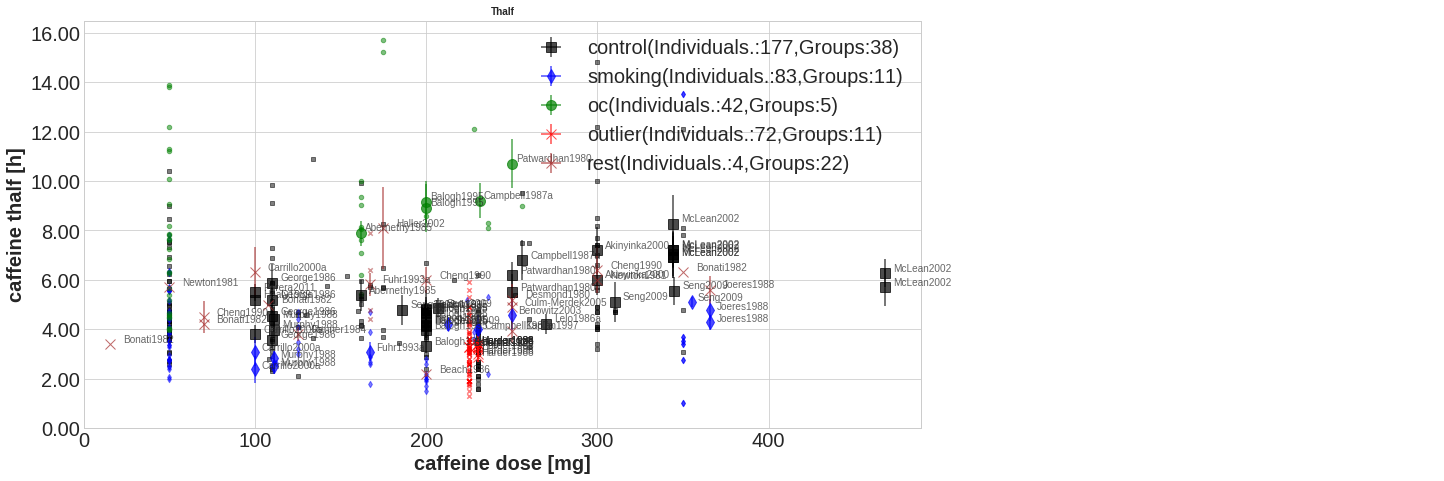

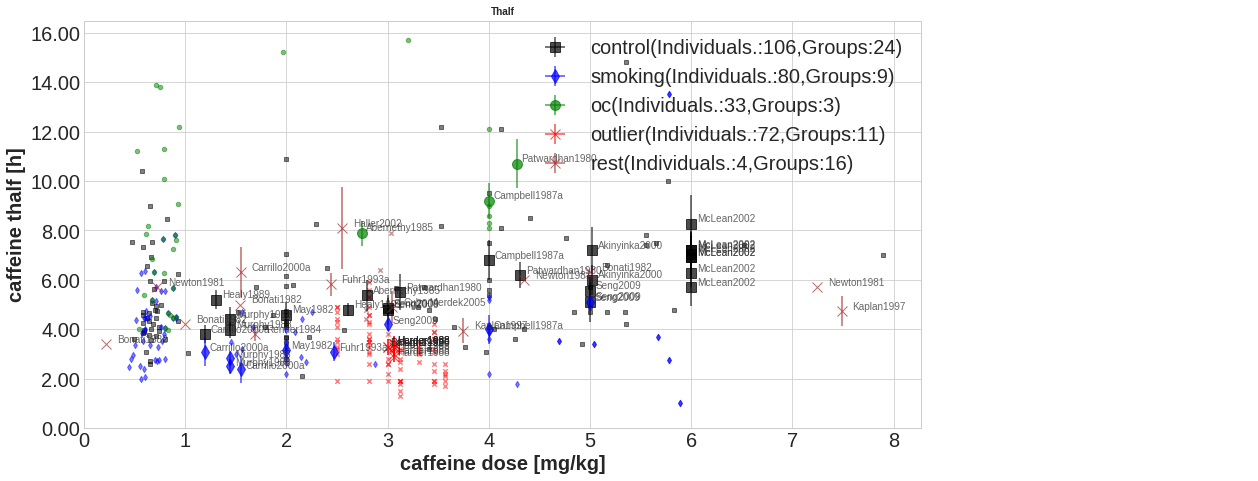

In [17]:
create_plots(caffeine_thalf,categories_soft,"reports/soft","thalf")

In [18]:
caffeine_mx = PkdbModel("caffeine_tmax",destination="3-inferred")
caffeine_mx.read()
caffeine_max = caffeine_mx.data
caffeine_max["outlier"] = False
caffeine_max.loc[caffeine_max["study"]== "Balogh1992","outlier"] = True
caffeine_max.loc[caffeine_max["study"]== "Harder1988","outlier"] = True
caffeine_max.loc[caffeine_max["study"]== "Harder1989","outlier"] = True

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


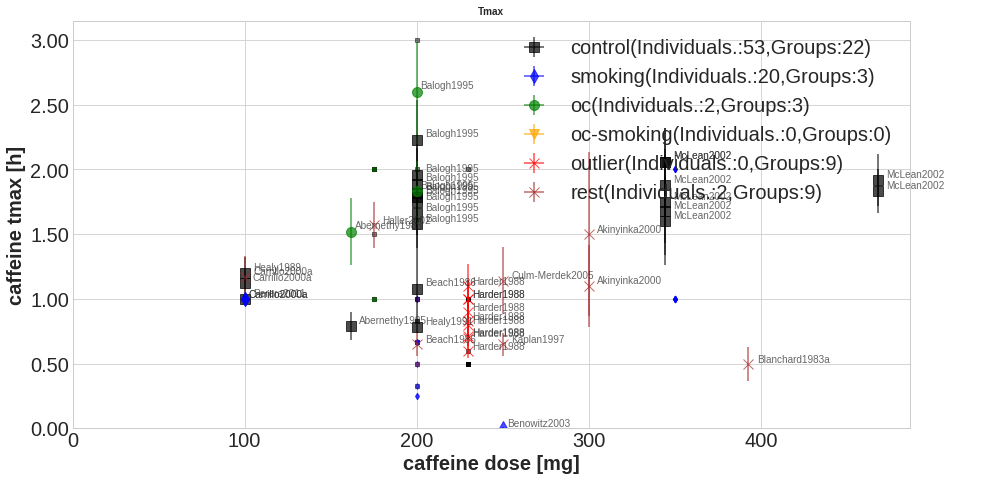

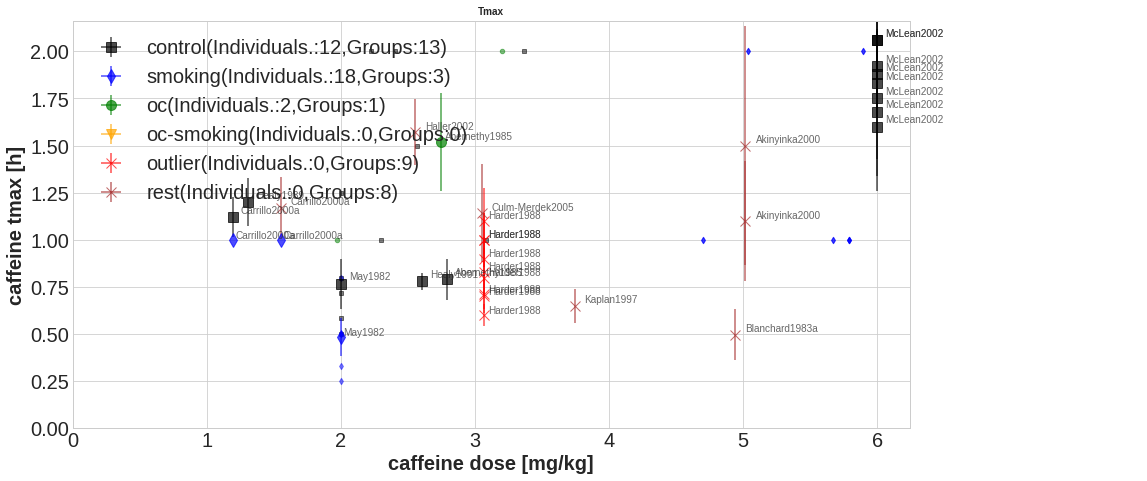

In [19]:
create_plots(caffeine_max,categories_strict,"reports/strict","tmax")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


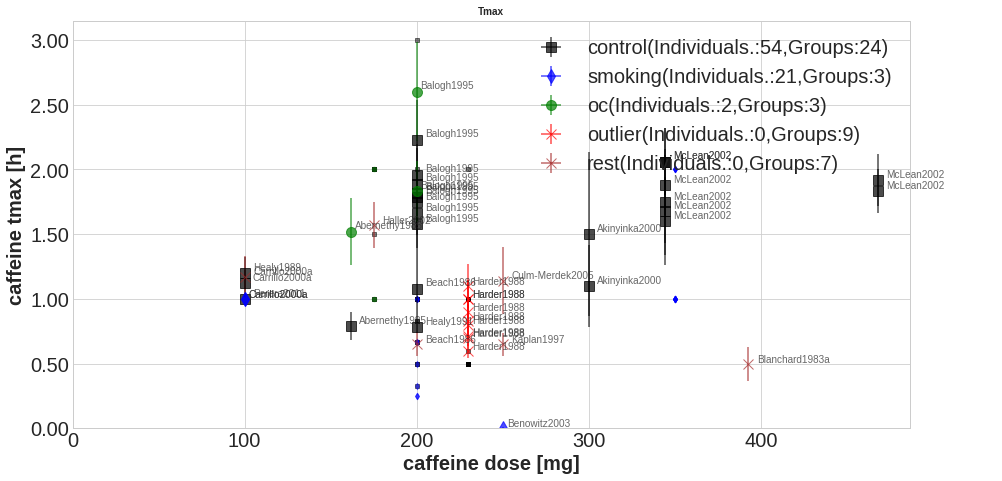

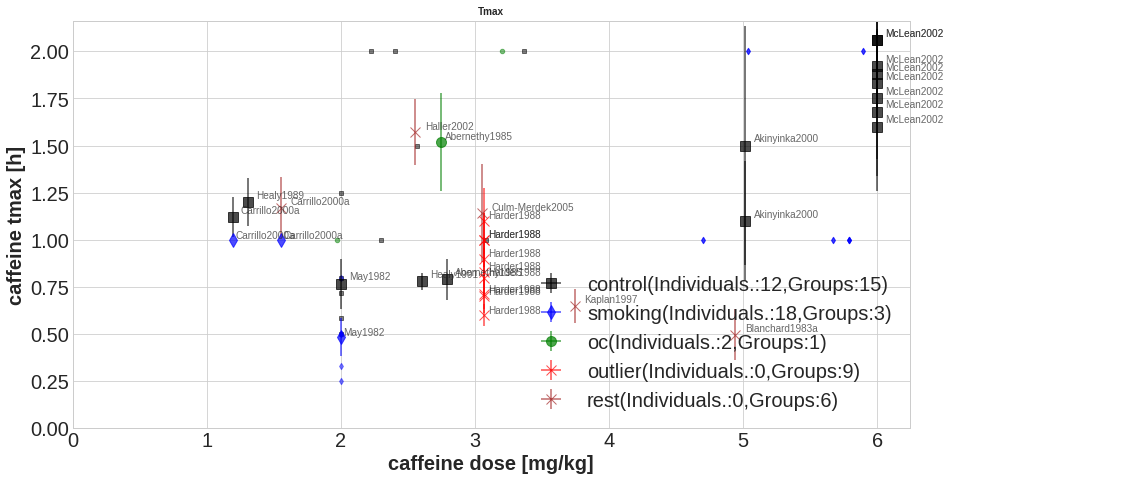

In [20]:
create_plots(caffeine_max,categories_soft,"reports/soft","tmax")

In [21]:
caffeine_instance = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


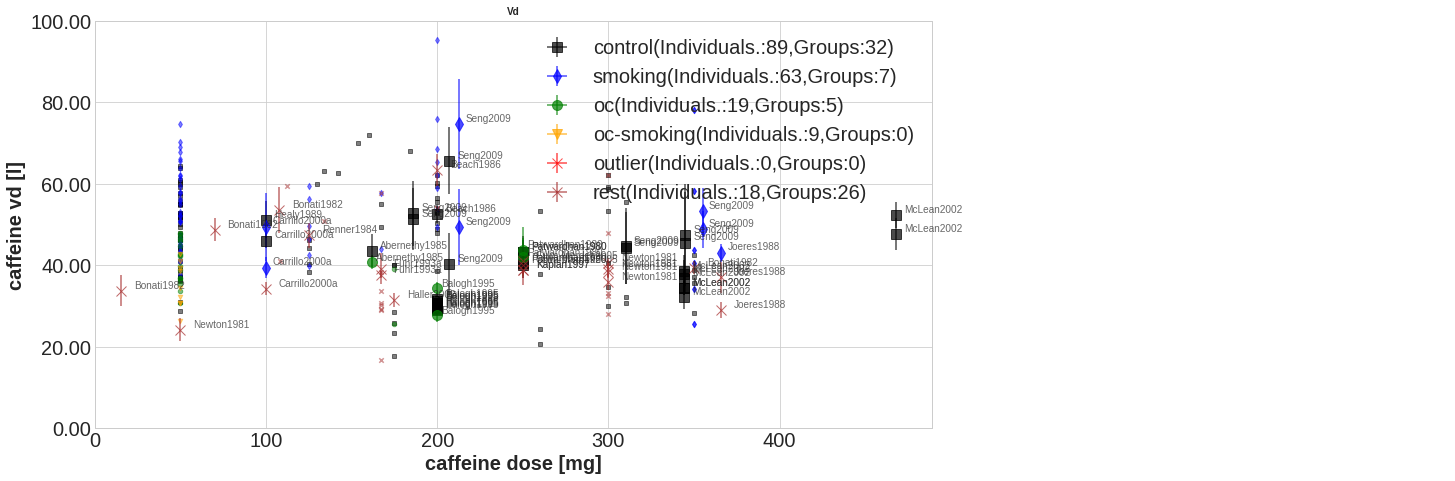

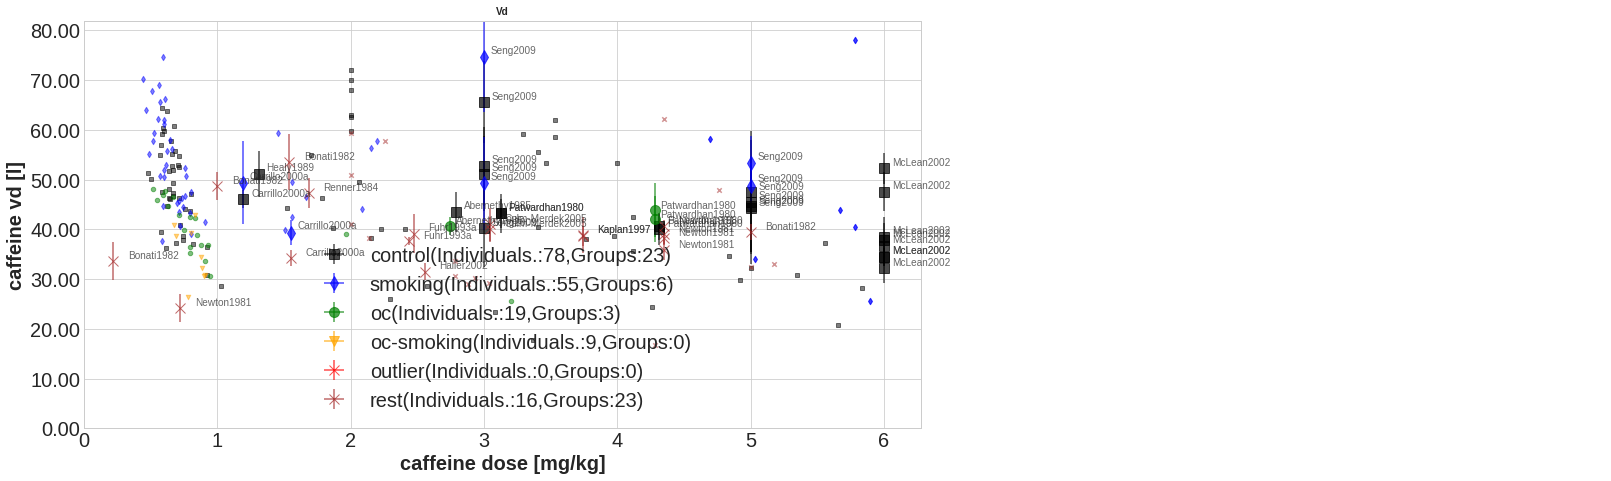

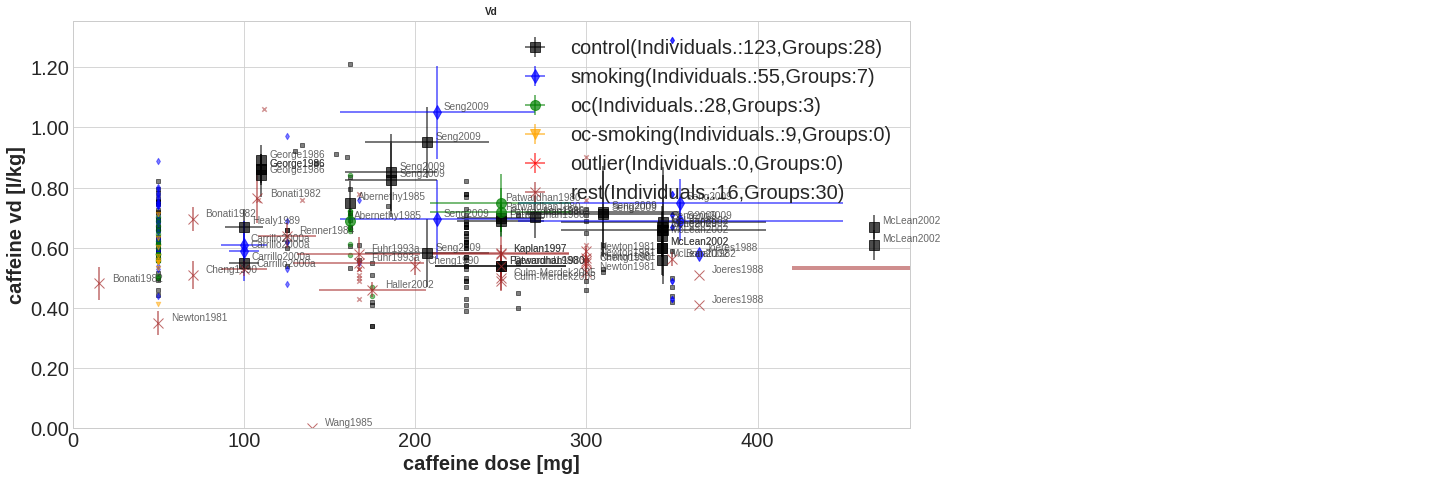

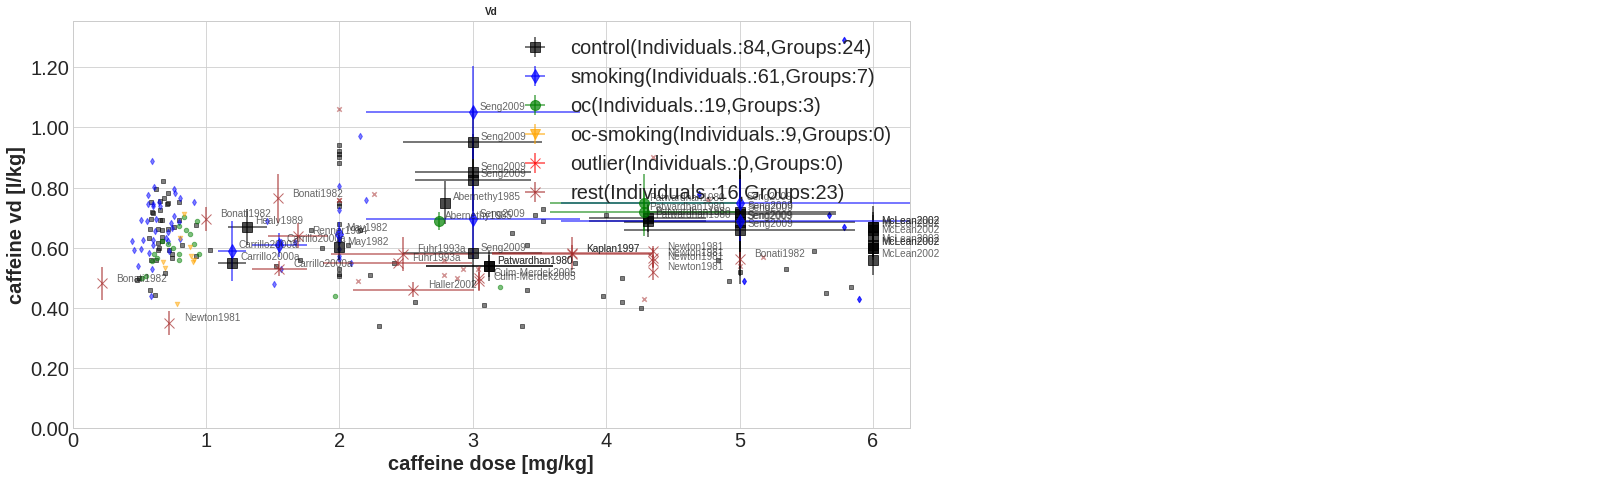

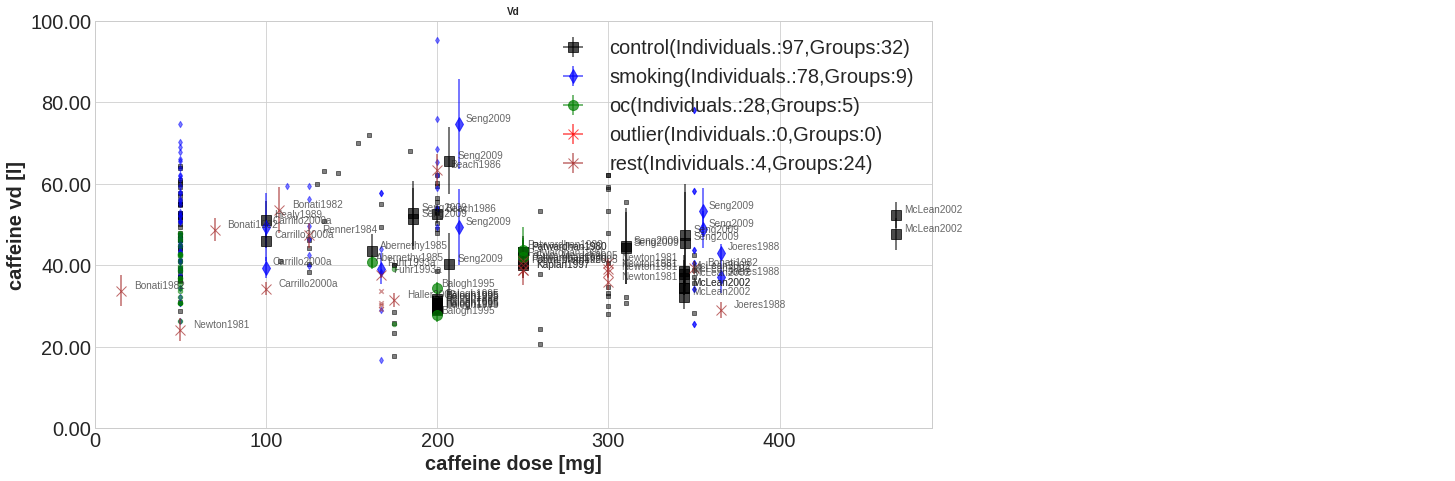

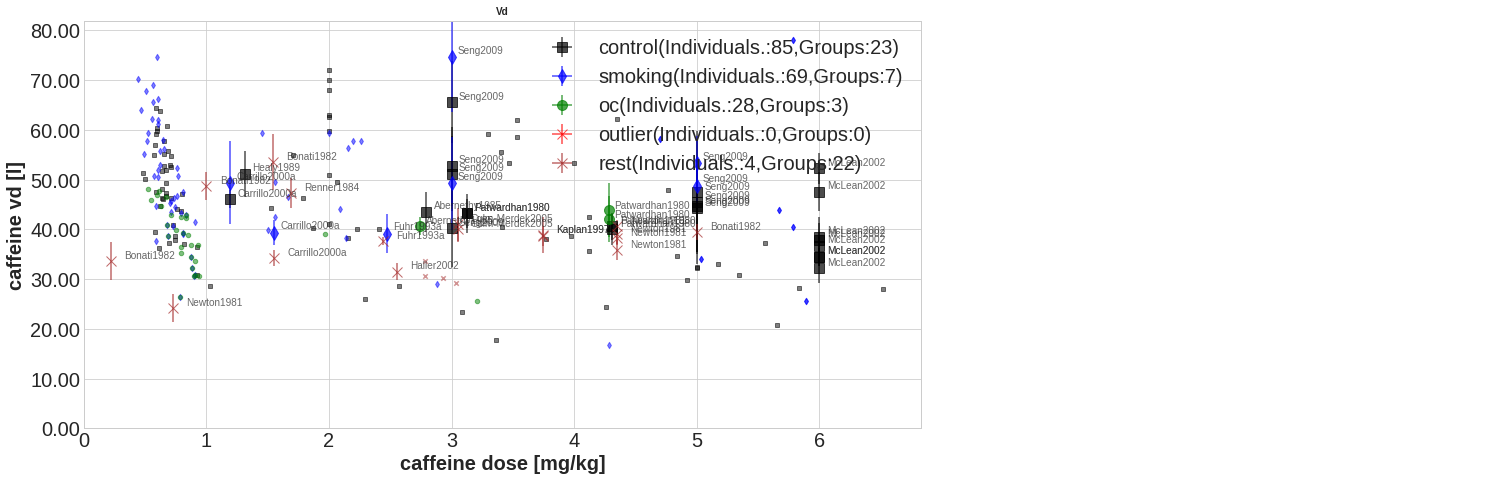

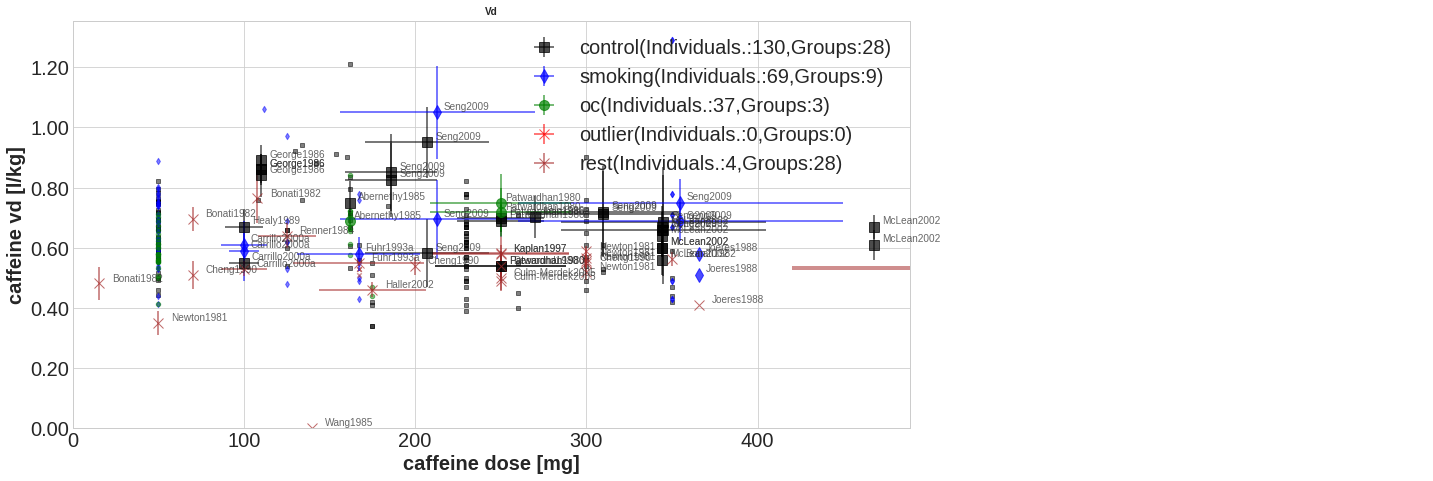

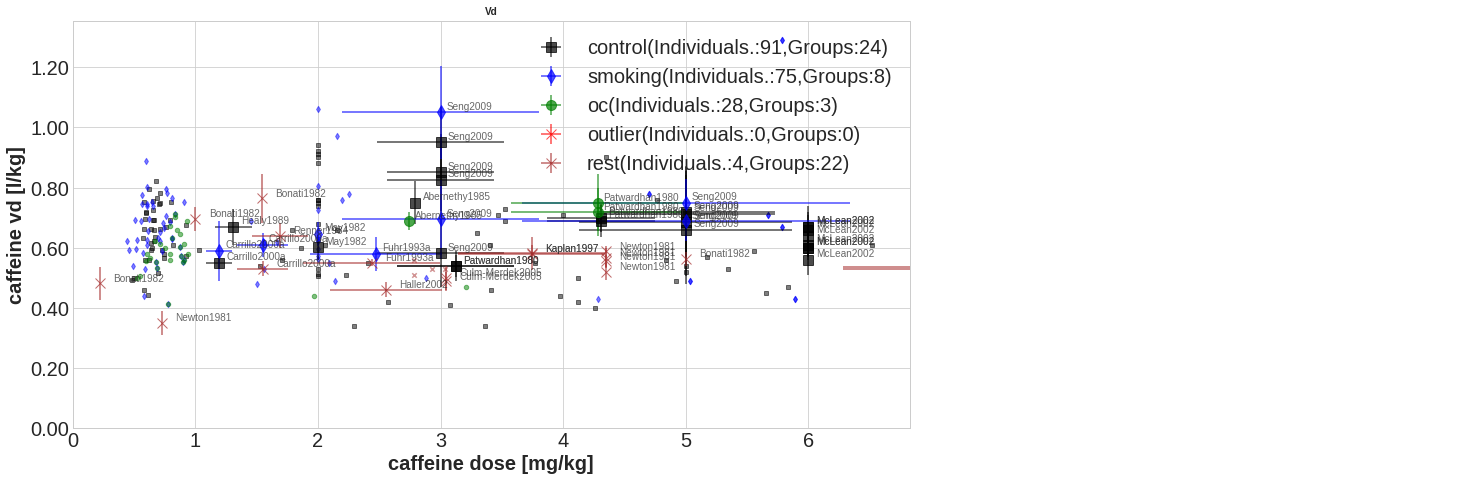

In [22]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","vd")
create_plots(caffeine_instance_data,categories_soft,"reports/soft","vd")

In [23]:
caffeine_instance = PkdbModel("caffeine_auc_inf",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


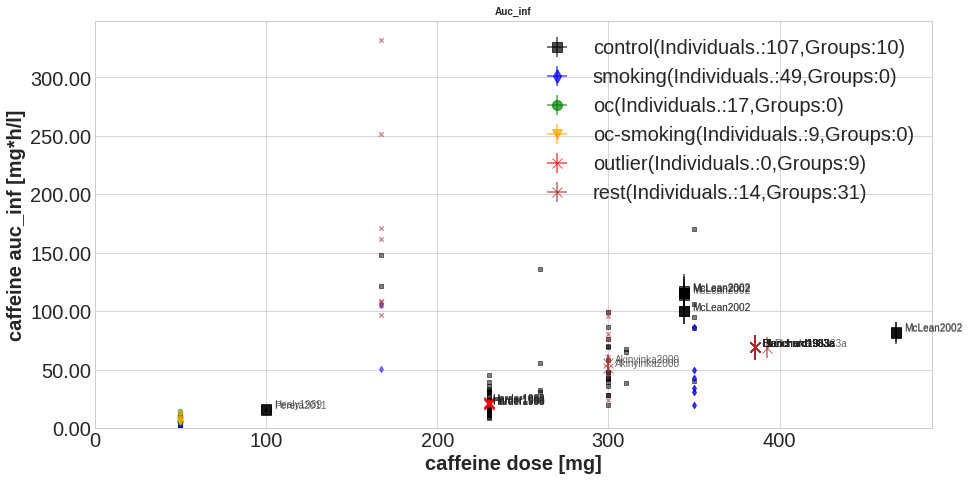

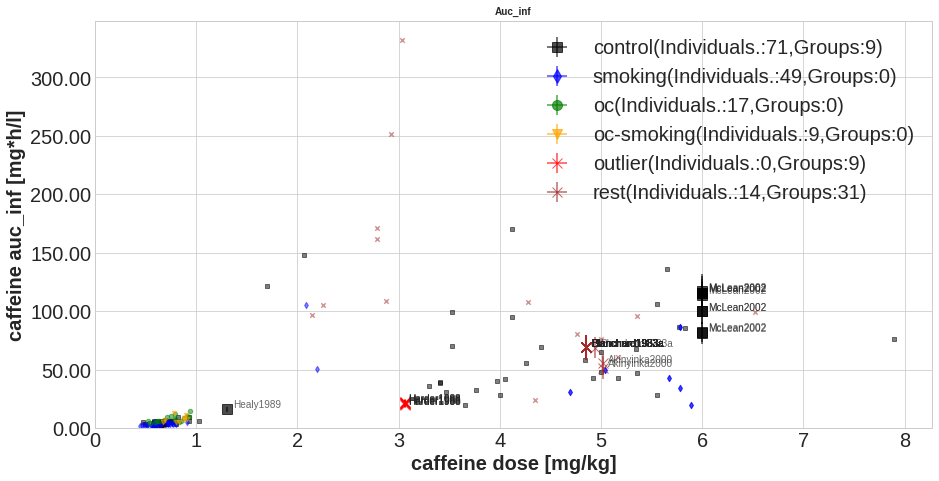

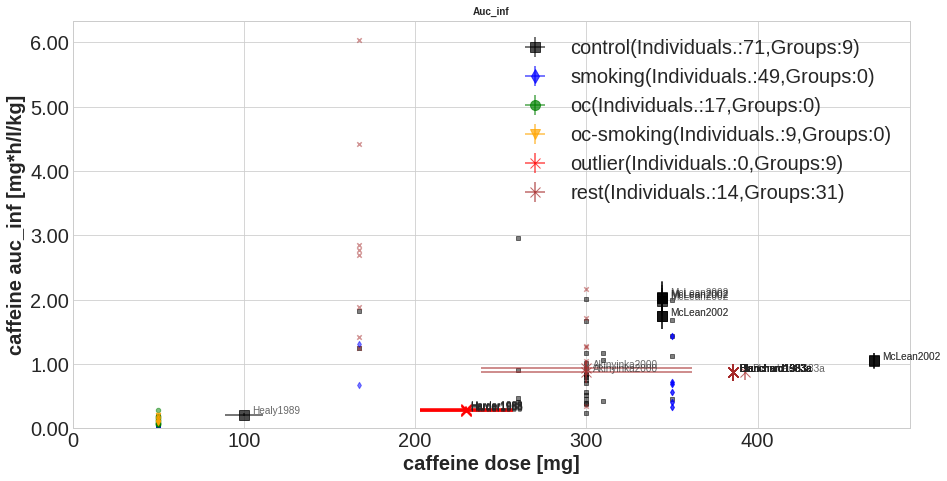

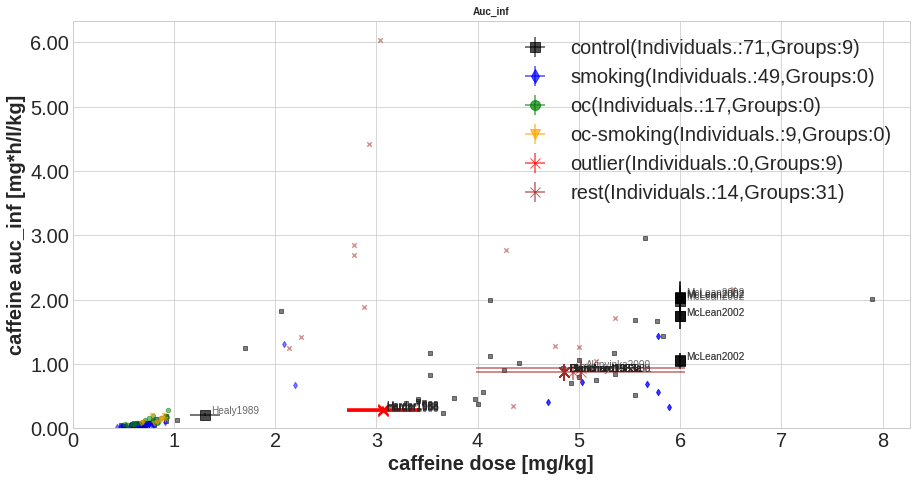

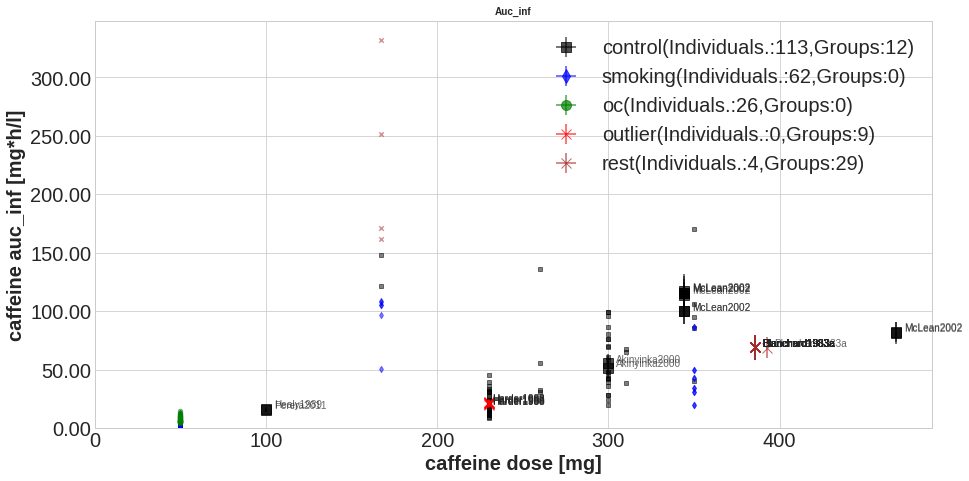

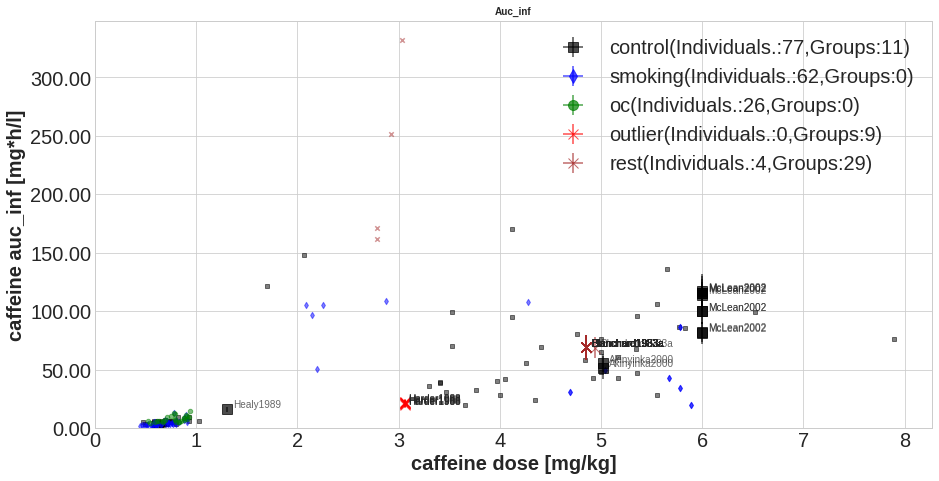

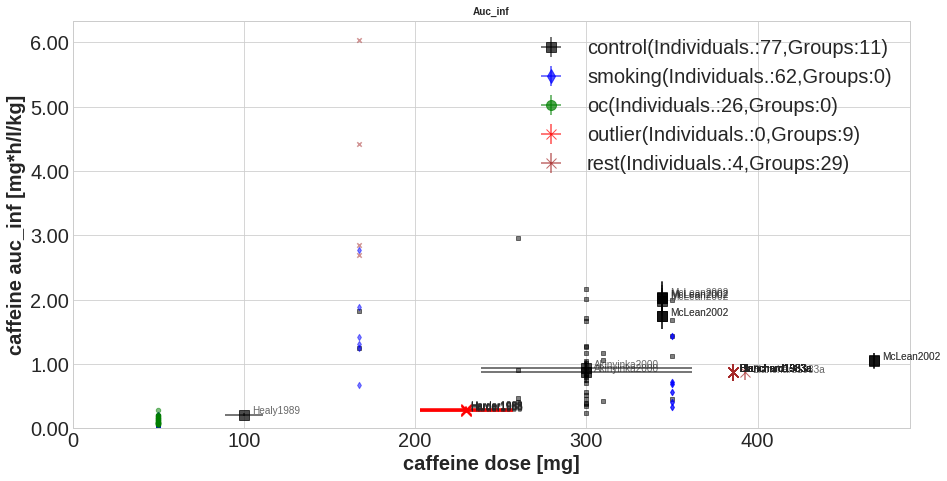

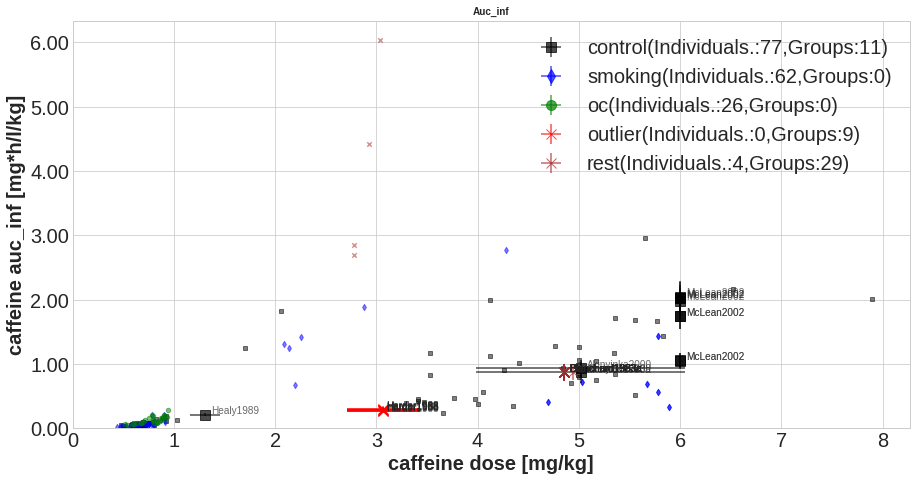

In [24]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","auc_inf")
create_plots(caffeine_instance_data,categories_soft,"reports/soft","auc_inf")